## Data preprocessing

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [2]:
# User specifies the fund they want to look at from available list
fund = input('Please enter ETF ticker: ')
df = pd.read_csv('data/'+fund+'.csv')

Please enter ETF ticker: QQQ


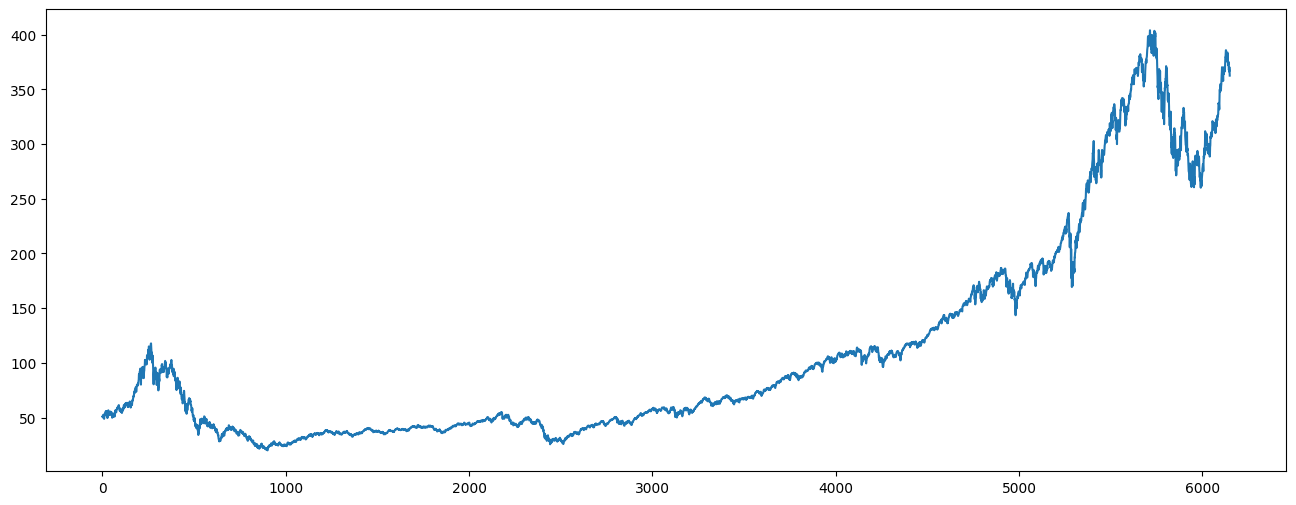

In [3]:
# Let's use QQQ as an example and see what its price series looks like
plt.figure(1, figsize=(16,6))
plt.plot(df.Close)

In [4]:
# All of the data frames have attributes open, high, low, close, adj close, and volume
#
# In our case, we only really care about close, as this tells us the final ETF price 
# of each day and determines the opening price of the ETF the following day

df = df[['Date', 'Close']] # We use [[]] to keep the data as a data frame rather than a series ([])
    
df.head(5)

,Date,Close
0,1999-03-10,51.0625
1,1999-03-11,51.3125
2,1999-03-12,50.0625
3,1999-03-15,51.5000
4,1999-03-16,51.9375


In [5]:
# In addition to the closing price of the stock, we also want normalize the values so we can see the returns
#
# We can do this by getting the percent change in the closing price. This also allows us to see if we have a 
# stationary process, a time series were the mean, variance, and correlation between features are the same

df.loc[:, 'Returns'] = df.Close.pct_change()
    
df.head(5)

,Date,Close,Returns
0,1999-03-10,51.0625,NaN
1,1999-03-11,51.3125,0.004896
2,1999-03-12,50.0625,-0.024361
3,1999-03-15,51.5000,0.028714
4,1999-03-16,51.9375,0.008495


In [6]:
# We now calculate the log returns (various statistical reasons for this)
    
df.loc[:, 'Log returns'] = np.log(1 + df.Returns)
    
df.head(5)

,Date,Close,Returns,Log returns
0,1999-03-10,51.0625,NaN,NaN
1,1999-03-11,51.3125,0.004896,0.004884
2,1999-03-12,50.0625,-0.024361,-0.024662
3,1999-03-15,51.5000,0.028714,0.028310
4,1999-03-16,51.9375,0.008495,0.008459


In [7]:
# Since there are no returns on the first day, we get NA values in our data set
# We can remove this with the dropna() function

df.dropna(inplace=True)
    
df.head(5)

,Date,Close,Returns,Log returns
1,1999-03-11,51.3125,0.004896,0.004884
2,1999-03-12,50.0625,-0.024361,-0.024662
3,1999-03-15,51.5000,0.028714,0.028310
4,1999-03-16,51.9375,0.008495,0.008459
5,1999-03-17,51.5625,-0.007220,-0.007246


In [8]:
# We will now create an array for our features: Close and Log returns

features = {}

X = df[['Close', 'Log returns']].values # We need this as an array to work with scikitlearn

X

array([[ 5.13125000e+01,  4.88401459e-03],
       [ 5.00625000e+01, -2.46621624e-02],
       [ 5.15000000e+01,  2.83095828e-02],
       ...,
       [ 3.70350006e+02,  1.11596918e-02],
       [ 3.66420013e+02, -1.06682687e-02],
       [ 3.62540009e+02, -1.06454141e-02]])

In [73]:
# The MinMaxScaler function standardizes all of the values
#
# Standardization is an important preprocessing step, as it prevents one feature from 
# dominating the other. MinMaxScaler in particular places all values on a scale from 0 to 1

from sklearn.preprocessing import MinMaxScaler

In [74]:
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[0.08140156, 0.46770829],
       [0.07814576, 0.36339538],
       [0.08188993, 0.55041237],
       [0.08302946, 0.48033073],
       [0.08205272, 0.42488178]])

In [11]:
# We will now create an array for our outputs: the Cost

y = [x[0] for x in X_scaled]
y[:5]

[0.08140156208843814,
 0.0781457601732395,
 0.08188993237571794,
 0.08302946304603746,
 0.08205272247147789]

### Spliting and creation of train and test sets

We are now going to split our data into training and testing sets. Typically, we want to reserve 80% of our data for training and 20% for testing

In [12]:
split = int(len(X_scaled) * 0.8)
split

4919

In [13]:
X_train = X_scaled[:split]
X_test = X_scaled[split:len(X_scaled)]
y_train = y[:split]
y_test = y[split:len(y)]

In [14]:
# As a safety measure, we want to assert that the lengths of the X and y training and testing sets
# are equal to each other in length

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

### Labeling

We will be using an LSTM (Long-short Term Memory) architecture to train our model, which means we have the benefit of working with a "memory"

This means that we have to set up a time step in order to determine how many steps in the past we want the LSTM to look (in more technical terms, it determines how many steps back the backpropagation algorithm looks back when calculating gradients for updating its weights during training

We will use a timestep of 3 to predict the closing ETF price at time t+1, where t refers to the current day

In [15]:
t_step = 3 # Timestep

Xtrain = []
Xtest = []
ytrain = []
ytest = []

# Loop to gather records in intervals of 3 from training sets
for i in range(t_step, len(X_train)):
    Xtrain.append(X_train[i - t_step : i, : X_train.shape[1]])
    ytrain.append(y_train[i]) # Closing price three days later 
    
# Loop to gather records in intervals of 3 from testing sets
for i in range(t_step, len(X_test)):
    Xtest.append(X_test[i - t_step : i, : X_test.shape[1]])
    ytest.append(y_test[i]) # Closing price three days later

Right now all of the values are standardized. If we want to convert the standardized cost back to the original cost, we do the following:

In [16]:
value = np.array(ytrain[0])
value = np.c_[value, np.zeros(value.shape)]
scaler.inverse_transform(value)

array([[51.9375    , -0.12759231]])

In [17]:
df.head(5)

,Date,Close,Returns,Log returns
1,1999-03-11,51.3125,0.004896,0.004884
2,1999-03-12,50.0625,-0.024361,-0.024662
3,1999-03-15,51.5000,0.028714,0.028310
4,1999-03-16,51.9375,0.008495,0.008459
5,1999-03-17,51.5625,-0.007220,-0.007246


If we look at the 4th day (3+1), its closing price is the same as ytrain[0] after being inversely transformed

For each layer of the LSTM network, we need the following information:

* Number of observations
* Timestep
* Number of features

In [18]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain)) # Make arrays into numpy arrays
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2])

Xtest, ytest = (np.array(Xtest), np.array(ytest)) # Make arrays into numpy arrays
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], Xtest.shape[2])

print(str(Xtrain.shape) + '\n' + str(Xtest.shape))
print('----------------')
print(str(ytrain.shape) + '\n' + str(ytest.shape))

(4916, 3, 2)
(1227, 3, 2)
----------------
(4916,)
(1227,)


### LSTM Model Training

We will use the keras python library to create our LSTM model

The LSTM layer takes 2 parameters: **units (neurons)** and an **input shape**

Neurons are essentially processing elements built into neural network layers. Each one of them works together to process the input features. The more neurons we have, the more complex trends we can caputre in our data. However, this requires more computational power

The input shape, for time series, is consistent of: 1) the timestep and 2) the number of features

The **Dense()** function creates a dense, or fully connected layer. It is used to connect every neuron from the previous layer to the current layer

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [20]:
model = Sequential() # The Sequential model is used to make a linear stack of layers (single input/output stream)
model.add(LSTM(4, input_shape = (Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1)) # We condense the information from the LSTM layer into one output unit
model.compile(loss = 'mean_squared_error', optimizer = 'adam') # Adam is an optimization algorithm 
model.fit(
    Xtrain, ytrain, epochs = 100, validation_data = (Xtest, ytest), batch_size = 16, verbose = 2
)

Epoch 1/100
308/308 - 1s - loss: 0.0046 - val_loss: 0.0439 - 758ms/epoch - 2ms/step
Epoch 2/100
308/308 - 0s - loss: 2.1764e-04 - val_loss: 0.0066 - 174ms/epoch - 564us/step
Epoch 3/100
308/308 - 0s - loss: 3.0718e-05 - val_loss: 0.0068 - 168ms/epoch - 547us/step
Epoch 4/100
308/308 - 0s - loss: 2.5488e-05 - val_loss: 0.0072 - 169ms/epoch - 547us/step
Epoch 5/100
308/308 - 0s - loss: 2.1122e-05 - val_loss: 0.0077 - 169ms/epoch - 549us/step
Epoch 6/100
308/308 - 0s - loss: 1.7959e-05 - val_loss: 0.0083 - 167ms/epoch - 543us/step
Epoch 7/100
308/308 - 0s - loss: 1.5506e-05 - val_loss: 0.0090 - 165ms/epoch - 537us/step
Epoch 8/100
308/308 - 0s - loss: 1.3973e-05 - val_loss: 0.0101 - 167ms/epoch - 542us/step
Epoch 9/100
308/308 - 0s - loss: 1.3335e-05 - val_loss: 0.0105 - 167ms/epoch - 543us/step
Epoch 10/100
308/308 - 0s - loss: 1.2566e-05 - val_loss: 0.0112 - 167ms/epoch - 542us/step
Epoch 11/100
308/308 - 0s - loss: 1.2216e-05 - val_loss: 0.0119 - 167ms/epoch - 542us/step
Epoch 12/100
3

Epoch 92/100
308/308 - 0s - loss: 9.9562e-06 - val_loss: 0.0047 - 168ms/epoch - 546us/step
Epoch 93/100
308/308 - 0s - loss: 1.0080e-05 - val_loss: 0.0042 - 168ms/epoch - 545us/step
Epoch 94/100
308/308 - 0s - loss: 1.0463e-05 - val_loss: 0.0043 - 169ms/epoch - 548us/step
Epoch 95/100
308/308 - 0s - loss: 1.0000e-05 - val_loss: 0.0044 - 167ms/epoch - 543us/step
Epoch 96/100
308/308 - 0s - loss: 9.8858e-06 - val_loss: 0.0044 - 167ms/epoch - 544us/step
Epoch 97/100
308/308 - 0s - loss: 1.0664e-05 - val_loss: 0.0046 - 167ms/epoch - 543us/step
Epoch 98/100
308/308 - 0s - loss: 9.8703e-06 - val_loss: 0.0044 - 168ms/epoch - 545us/step
Epoch 99/100
308/308 - 0s - loss: 1.0071e-05 - val_loss: 0.0044 - 168ms/epoch - 545us/step
Epoch 100/100
308/308 - 0s - loss: 9.8835e-06 - val_loss: 0.0043 - 167ms/epoch - 543us/step


Just some info on the parameters for **model.fit()**:
* *Xtrain, ytrain*: training data
* *epochs = 100*: an epoch is a complete pass through the entire training dataset during the training process, so the model sees and learns from every example in the training data once
    * In this case, we make 100 passes through the entire data set
* *validation_data = (Xtest, ytest)*: fairly obvious, this is our testing/validation data. We use the feature data from Xtest to make predictions on ytest and then calculate the mean squared error as our loss function
* *batch_size = 16*: typically data is processed in batches rather than all at once. Here, we can have a maximum of 16 observations per batch
* *verbose = 1*: the verbose parameter simply allows us to choose how we want to see the progress of the fitted model
    * 0 = silent
    * 1 = progress bar for every epoch [============]
    * 2 = simply mentions every number of epoch (ex: Epoch 96/100)
Note the val_loss, as this tells us the validation loss/error. By the 100th epoch, we have a validation loss of 0.003

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 112       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 117 (468.00 Byte)
Trainable params: 117 (468.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Prediction

Now that our model is trained, we can actually test it

In [26]:
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)

39/39 [==============================] - 0s 284us/step


In order to be able to invert the predictions to give us the closing price (one feature), we need *two* features. To do this, we concatenate an array of 0s

In [27]:
trainPredict = np.c_[trainPredict, np.zeros(trainPredict.shape)]
testPredict = np.c_[testPredict, np.zeros(testPredict.shape)]

In [28]:
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = [x[0] for x in trainPredict]

testPredict = scaler.inverse_transform(testPredict)
testPredict = [x[0] for x in testPredict]

In [29]:
print(trainPredict[:5])
print(testPredict[:5])

[51.433125284410664, 51.729965229623055, 51.32388559867929, 52.42405729863928, 51.061054153916245]
[184.81138614732558, 185.33910287681488, 184.83494523637435, 185.0458328372767, 181.90900706616395]


To help us gauge how accurate our predictions are, we can use the *mean_squared_error*

In [30]:
from sklearn.metrics import mean_squared_error as mse

In [31]:
testScore = mse([x[0][0] for x in Xtest], testPredict, squared = False)
print("Squared MSE: {:.2f}".format(testScore))

Squared MSE: 262.74


In [32]:
df.head(5)

,Date,Close,Returns,Log returns
1,1999-03-11,51.3125,0.004896,0.004884
2,1999-03-12,50.0625,-0.024361,-0.024662
3,1999-03-15,51.5000,0.028714,0.028310
4,1999-03-16,51.9375,0.008495,0.008459
5,1999-03-17,51.5625,-0.007220,-0.007246


In [33]:
Xtest[:5]

array([[[0.4277082 , 0.45295696],
        [0.43177143, 0.48022809],
        [0.43166723, 0.44970506]],

       [[0.43177143, 0.48022809],
        [0.43166723, 0.44970506],
        [0.432657  , 0.45767899]],

       [[0.43166723, 0.44970506],
        [0.432657  , 0.45767899],
        [0.43156306, 0.44249147]],

       [[0.432657  , 0.45767899],
        [0.43156306, 0.44249147],
        [0.43208398, 0.45426451]],

       [[0.43156306, 0.44249147],
        [0.43208398, 0.45426451],
        [0.42278543, 0.38202517]]])

### Making new predictions

We are now going to make completely new predictions with the model we trained. First we are going to define some helper functions:

In [147]:
def find_closing_price(x):
    x = np.c_[x, np.zeros(x.shape)]
    x = scaler.inverse_transform(x)
    x = [i[0] for i in x]
    return(x)

In [204]:
def add_input(arr, new_inp):
    new_arr = np.delete(arr, 0, axis=1)
    new_arr = np.append(new_arr, [new_inp], axis=1)
    return(new_arr)

Now, we will iteratively predict a new closing price and use the previous day's closing price as the next input/log return. This will allow us to generate as many new predictions as we want

In [214]:
new_inps = np.array([Xtest[len(Xtest) - 1]])
new_outs = np.array(ytest[-3:])

iterations = 50

for _ in range(iterations):
    new_pred = model.predict(new_inps)[0][0]
    new_pred_pr = find_closing_price(new_pred)[0] # Function returns an array so we extract the numeric value
    
    prev_close = new_outs[len(new_outs) - 1]
    prev_close_pr = find_closing_price(prev_close)[0]
    
    pct_change = (abs(new_pred_pr - prev_close_pr) / prev_close_pr) * 100
    log_return = np.array([np.log(1 + pct_change)])[0]
    new_inp = scaler.transform([[new_pred_pr, log_return]])
    
    new_inps = add_input(new_inps, new_inp)
    new_outs = np.append(new_outs, new_pred)

1/1 [==============================] - 0s 13ms/step


Now that we have all of our closing prices, we can inverse t

In [216]:
new_outs = find_closing_price(new_outs[3:])